# Trade Flow Return Predictions in Cryptocurrency Markets

**Objective:** Assess whether short-term trade flow contains predictive information about future returns in BTC-USDT markets.

**Workflow:** Following proper quant trading methodology:
1. **In-Sample Discovery** (Training): Build model, discover patterns, analyze characteristics
2. **Out-of-Sample Validation** (Testing): Validate patterns hold on unseen data

**Date:** January 28, 2026

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Dict, Tuple

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
pd.options.display.float_format = '{:.6f}'.format

## 1. Helper Functions

### Mathematical Framework

**Trade Flow** $F_i^{(\tau)}$: Net signed quantity over $(t_i - \tau, t_i)$
$$F_i^{(\tau)} = \sum_{j: t_i - \tau < t_j < t_i} q_j \cdot \mathbb{1}_{\text{buy}_j} - q_j \cdot \mathbb{1}_{\text{sell}_j}$$

**Forward Return** $r_i^{(T)}$: Price change from $t_i$ to $t_i + T$
$$r_i^{(T)} = \frac{P(t_i + T) - P(t_i)}{P(t_i)}$$

**Regression Model**: Through-origin OLS
$$r_i^{(T)} = \beta \cdot F_i^{(\tau)} + \epsilon_i \quad \Rightarrow \quad \beta = \frac{\sum F_i r_i}{\sum F_i^2}$$

In [2]:
# ============================================================================
# DATA PROCESSING
# ============================================================================

def load_and_split(filepath: str, train_frac: float = 0.4) -> Dict[str, pd.DataFrame]:
    """Load parquet file and split by exchange into train/test sets."""
    df = pd.read_parquet(filepath)
    data = {}
    
    for exchange in df['Exchange'].unique():
        exchange_df = df[df['Exchange'] == exchange].sort_values('ts').reset_index(drop=True)
        split_idx = int(len(exchange_df) * train_frac)
        data[f'{exchange.lower()}_train'] = exchange_df.iloc[:split_idx]
        data[f'{exchange.lower()}_test'] = exchange_df.iloc[split_idx:]
    
    return data


def compute_flow_and_returns(
    df: pd.DataFrame,
    tau_seconds: float = 1.0,
    T_seconds: float = 1.0
) -> pd.DataFrame:
    """
    Compute trade flow F_tau and forward returns r_T for each trade.
    
    Parameters:
    -----------
    df : Trade data with columns [ts, side, qty, trade_price]
    tau_seconds : Lookback window for trade flow
    T_seconds : Forward window for returns
    
    Returns:
    --------
    DataFrame with added columns: signed_qty, F_tau, r_T
    """
    out = df.sort_values('ts').reset_index(drop=True).copy()
    
    # Signed quantity: buys (+), sells (-)
    out['signed_qty'] = np.where(out['side'] == 'B', out['qty'], -out['qty']).astype(float)
    
    # Convert timestamps to nanoseconds
    ts_ns = out['ts'].values.astype('datetime64[ns]').astype('int64')
    tau_ns = int(pd.Timedelta(seconds=tau_seconds) / pd.Timedelta('1ns'))
    T_ns = int(pd.Timedelta(seconds=T_seconds) / pd.Timedelta('1ns'))
    
    n = len(out)
    signed_qty = out['signed_qty'].values
    price = out['trade_price'].astype(float).values
    
    # Cumulative sum for efficient window queries
    cs = np.concatenate([[0], np.cumsum(signed_qty)])
    
    # Trade flow: sum over (t_i - tau, t_i), excluding trades at t_i
    left_idx = np.searchsorted(ts_ns, ts_ns - tau_ns, side='left')
    right_idx = np.searchsorted(ts_ns, ts_ns, side='left')  # Excludes t_i
    out['F_tau'] = cs[right_idx] - cs[left_idx]
    
    # Forward returns: (P(t+T) - P(t)) / P(t)
    fwd_idx = np.searchsorted(ts_ns, ts_ns + T_ns, side='left')
    fwd_price = np.full(n, np.nan, dtype=np.float64)
    valid = fwd_idx < n
    fwd_price[valid] = price[fwd_idx[valid]]
    out['r_T'] = (fwd_price - price) / price
    
    return out


# ============================================================================
# MODEL ESTIMATION
# ============================================================================

def fit_beta(df: pd.DataFrame) -> float:
    """Estimate beta via through-origin OLS: β = (X'y) / (X'X)"""
    mask = df['F_tau'].notna() & df['r_T'].notna()
    X = df.loc[mask, 'F_tau'].values
    y = df.loc[mask, 'r_T'].values
    
    denom = X @ X
    return float((X @ y) / denom) if denom != 0 else np.nan


def generate_predictions(df: pd.DataFrame, beta: float) -> pd.DataFrame:
    """Generate predictions r_hat = beta * F_tau"""
    df = df.copy()
    df['r_hat'] = beta * df['F_tau']
    return df


# ============================================================================
# TRADING STRATEGY
# ============================================================================

def apply_threshold(df: pd.DataFrame, quantile: float = 0.95) -> Tuple[pd.DataFrame, float]:
    """Apply threshold to generate trading signals at target participation rate."""
    df = df.copy()
    j = df['r_hat'].abs().quantile(quantile)
    df['trade_signal'] = df['r_hat'].abs() > j
    return df, j


def compute_pnl(df: pd.DataFrame, tc_bps: float = 0) -> pd.DataFrame:
    """
    Compute P&L for trades with optional transaction costs.
    
    PL_i = direction * qty * price * r_T - TC
    """
    trades = df[df['trade_signal']].copy()
    trades['direction'] = np.sign(trades['r_hat'])
    trades['pl_notional'] = trades['direction'] * trades['qty'] * trades['trade_price'] * trades['r_T']
    trades['tc'] = tc_bps * 1e-4 * trades['qty'] * trades['trade_price']
    trades['pl_net'] = trades['pl_notional'] - trades['tc']
    return trades


# ============================================================================
# PERFORMANCE METRICS
# ============================================================================

def compute_metrics(pl_series: pd.Series) -> Dict:
    """Compute comprehensive performance metrics."""
    cum_pl = pl_series.cumsum()
    
    # Sharpe ratio
    sharpe = pl_series.mean() / pl_series.std() if pl_series.std() > 0 else np.nan
    
    # Maximum drawdown
    running_max = cum_pl.cummax()
    drawdown = cum_pl - running_max
    max_dd = drawdown.min()
    
    return {
        'total_pl': pl_series.sum(),
        'mean_pl': pl_series.mean(),
        'std_pl': pl_series.std(),
        'sharpe': sharpe,
        'max_dd': max_dd,
        'skew': stats.skew(pl_series),
        'kurtosis': stats.kurtosis(pl_series),
        'win_rate': (pl_series > 0).mean(),
        'p01': pl_series.quantile(0.01),
        'p05': pl_series.quantile(0.05),
        'p95': pl_series.quantile(0.95),
        'p99': pl_series.quantile(0.99),
        'cum_pl': cum_pl
    }


def assess_beta_stability(df: pd.DataFrame, n_splits: int = 5) -> pd.DataFrame:
    """Assess beta stability across sub-periods."""
    split_size = len(df) // n_splits
    results = []
    
    for i in range(n_splits):
        start = i * split_size
        end = (i + 1) * split_size if i < n_splits - 1 else len(df)
        sub_df = df.iloc[start:end]
        beta_i = fit_beta(sub_df)
        results.append({'period': i+1, 'beta': beta_i, 'n_obs': len(sub_df)})
    
    return pd.DataFrame(results)


def add_volatility(df: pd.DataFrame, window: str = '300s') -> pd.DataFrame:
    """Add 5-minute realized volatility to dataframe."""
    df = df.copy()
    
    # Ensure ts is a column and sorted
    if 'ts' not in df.columns:
        df = df.reset_index()
    
    df = df.sort_values('ts').reset_index(drop=True)
    df['returns'] = df['trade_price'].pct_change()
    
    # Set ts as index for time-based rolling
    df_indexed = df.set_index('ts')
    df_indexed['vol_5min'] = df_indexed['returns'].rolling(window=window).std() * np.sqrt(252*24*60)
    df = df_indexed.reset_index()
    
    return df


def analyze_by_volatility(trades: pd.DataFrame, full_df: pd.DataFrame) -> pd.DataFrame:
    """Analyze P&L conditional on realized volatility."""
    # Merge volatility to trades
    trades_vol = trades.merge(full_df[['ts', 'vol_5min']], on='ts', how='left')
    
    # Group by volatility deciles
    trades_vol['vol_decile'] = pd.qcut(trades_vol['vol_5min'].dropna(), q=10, labels=False, duplicates='drop')
    
    vol_analysis = trades_vol.groupby('vol_decile').agg({
        'pl_net': ['mean', 'std', 'count'],
        'vol_5min': 'mean'
    }).round(6)
    
    return vol_analysis


# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_performance(metrics_gross: Dict, metrics_net: Dict, trades: pd.DataFrame, title_suffix: str = ""):
    """Comprehensive performance visualization."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Cumulative P&L
    axes[0, 0].plot(metrics_gross['cum_pl'].values, label='Gross', linewidth=1.5, alpha=0.8)
    axes[0, 0].plot(metrics_net['cum_pl'].values, label='Net', linewidth=1.5, alpha=0.8)
    axes[0, 0].set_title(f'Cumulative P&L{title_suffix}', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Trade Number')
    axes[0, 0].set_ylabel('Cumulative P&L ($)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # P&L Distribution
    axes[0, 1].hist(trades['pl_net'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[0, 1].set_title(f'P&L Distribution (Net){title_suffix}', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('P&L per Trade ($)')
    axes[0, 1].set_ylabel('Frequency')
    
    # Drawdown
    running_max = metrics_net['cum_pl'].cummax()
    drawdown = metrics_net['cum_pl'] - running_max
    axes[1, 0].fill_between(range(len(drawdown)), drawdown, 0, alpha=0.5, color='red')
    axes[1, 0].set_title(f'Drawdown (Net){title_suffix}', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Trade Number')
    axes[1, 0].set_ylabel('Drawdown ($)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Rolling Sharpe
    window = min(100, len(trades) // 10)
    rolling_sharpe = trades['pl_net'].rolling(window).mean() / trades['pl_net'].rolling(window).std()
    axes[1, 1].plot(rolling_sharpe, linewidth=1.5, color='green')
    axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=1)
    axes[1, 1].set_title(f'Rolling Sharpe ({window}-trade window){title_suffix}', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Trade Number')
    axes[1, 1].set_ylabel('Sharpe Ratio')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def plot_volatility_analysis(vol_analysis: pd.DataFrame, title_suffix: str = ""):
    """Plot P&L by volatility decile."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    mean_pl = vol_analysis[('pl_net', 'mean')].values
    std_pl = vol_analysis[('pl_net', 'std')].values
    count = vol_analysis[('pl_net', 'count')].values
    stderr = std_pl / np.sqrt(count)
    
    ax.bar(range(len(mean_pl)), mean_pl, yerr=stderr, capsize=5, alpha=0.7, color='steelblue')
    ax.axhline(0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Volatility Decile (0=Low, 9=High)', fontsize=11)
    ax.set_ylabel('Mean P&L per Trade ($)', fontsize=11)
    ax.set_title(f'P&L vs Market Volatility{title_suffix}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    return fig

## 2. Data Loading

In [3]:
# Load and split data
data = load_and_split('data/BTC-USDT_fewer_trades.parquet', train_frac=0.4)

# Extract BINANCE data
train = data['binance_train']
test = data['binance_test']

# Summary
summary = pd.DataFrame([
    {'Exchange': 'BINANCE', 'Split': 'Train', 'Observations': f"{len(train):,}"},
    {'Exchange': 'BINANCE', 'Split': 'Test', 'Observations': f"{len(test):,}"}
])
display(summary)

,Exchange,Split,Observations
0,BINANCE,Train,"949,695"
1,BINANCE,Test,"1,424,544"


## 3. Model Training

Parameters: $\tau = 1s$, $T = 1s$

In [4]:
TAU, T = 1.0, 1.0

# Compute features on training data
train_aug = compute_flow_and_returns(train, tau_seconds=TAU, T_seconds=T)
beta = fit_beta(train_aug)

# Training summary
valid = train_aug[['F_tau', 'r_T']].notna().all(axis=1).sum()
training_results = pd.DataFrame([{
    'Parameter': 'β',
    'Estimate': f'{beta:.6e}',
    'Valid Obs': f'{valid:,}'
}])
display(training_results)

,Parameter,Estimate,Valid Obs
0,β,9.178915e-06,"949,316"


---
# PART 1: IN-SAMPLE DISCOVERY (Training Set)

**Goal:** Understand the model's behavior, discover patterns, and determine optimal parameters using training data only.

---

## 4. In-Sample: Generate Trading Signals

In [5]:
# Generate predictions on training data
train_aug = generate_predictions(train_aug, beta)

# Apply threshold (target 5% participation)
train_aug, j_train = apply_threshold(train_aug, quantile=0.95)

# Strategy summary
strategy_summary_train = pd.DataFrame([{
    'Metric': 'Threshold (j)',
    'Value': f'{j_train:.6e}'
}, {
    'Metric': 'Participation Rate',
    'Value': f"{train_aug['trade_signal'].mean():.2%}"
}, {
    'Metric': 'Number of Trades',
    'Value': f"{train_aug['trade_signal'].sum():,}"
}])
print("\n=== IN-SAMPLE (TRAINING) STRATEGY ===")
display(strategy_summary_train)


=== IN-SAMPLE (TRAINING) STRATEGY ===


,Metric,Value
0,Threshold (j),5.127920e-05
1,Participation Rate,5.00%
2,Number of Trades,"47,469"


## 5. In-Sample: Performance Metrics

In [6]:
# Compute P&L on training data
trades_train_gross = compute_pnl(train_aug, tc_bps=0)
trades_train_net = compute_pnl(train_aug, tc_bps=5)

# Compute metrics
metrics_train_gross = compute_metrics(trades_train_gross['pl_notional'])
metrics_train_net = compute_metrics(trades_train_net['pl_net'])

# Performance table
perf_table_train = pd.DataFrame([
    {'Metric': 'Total P&L', 'Gross': f"${metrics_train_gross['total_pl']:,.2f}", 'Net (5bps TC)': f"${metrics_train_net['total_pl']:,.2f}"},
    {'Metric': 'Mean P&L/Trade', 'Gross': f"${metrics_train_gross['mean_pl']:.4f}", 'Net (5bps TC)': f"${metrics_train_net['mean_pl']:.4f}"},
    {'Metric': 'Sharpe Ratio', 'Gross': f"{metrics_train_gross['sharpe']:.3f}", 'Net (5bps TC)': f"{metrics_train_net['sharpe']:.3f}"},
    {'Metric': 'Max Drawdown', 'Gross': f"${metrics_train_gross['max_dd']:,.2f}", 'Net (5bps TC)': f"${metrics_train_net['max_dd']:,.2f}"},
    {'Metric': 'Win Rate', 'Gross': f"{metrics_train_gross['win_rate']:.2%}", 'Net (5bps TC)': f"{metrics_train_net['win_rate']:.2%}"},
    {'Metric': 'Skewness', 'Gross': f"{metrics_train_gross['skew']:.3f}", 'Net (5bps TC)': f"{metrics_train_net['skew']:.3f}"},
    {'Metric': 'Kurtosis', 'Gross': f"{metrics_train_gross['kurtosis']:.3f}", 'Net (5bps TC)': f"{metrics_train_net['kurtosis']:.3f}"}
])

print("\n=== IN-SAMPLE PERFORMANCE ===")
display(perf_table_train)

# Tail statistics
tail_table_train = pd.DataFrame([
    {'Percentile': '1%', 'Gross': f"${metrics_train_gross['p01']:.4f}", 'Net': f"${metrics_train_net['p01']:.4f}"},
    {'Percentile': '5%', 'Gross': f"${metrics_train_gross['p05']:.4f}", 'Net': f"${metrics_train_net['p05']:.4f}"},
    {'Percentile': '95%', 'Gross': f"${metrics_train_gross['p95']:.4f}", 'Net': f"${metrics_train_net['p95']:.4f}"},
    {'Percentile': '99%', 'Gross': f"${metrics_train_gross['p99']:.4f}", 'Net': f"${metrics_train_net['p99']:.4f}"}
])

print("\nP&L Tail Statistics:")
display(tail_table_train)


=== IN-SAMPLE PERFORMANCE ===


,Metric,Gross,Net (5bps TC)
0,Total P&L,"$10,144.19","$-25,646.67"
1,Mean P&L/Trade,$0.2137,$-0.5403
2,Sharpe Ratio,0.077,-0.134
3,Max Drawdown,$-287.03,"$-25,645.98"
4,Win Rate,73.66%,1.86%
5,Skewness,41.931,-26.335
6,Kurtosis,3198.101,1265.327



P&L Tail Statistics:


,Percentile,Gross,Net
0,1%,$-0.6586,$-11.4373
1,5%,$-0.0128,$-1.8270
2,95%,$0.5929,$-0.0007
3,99%,$5.2886,$0.0010


## 6. In-Sample: Visualization

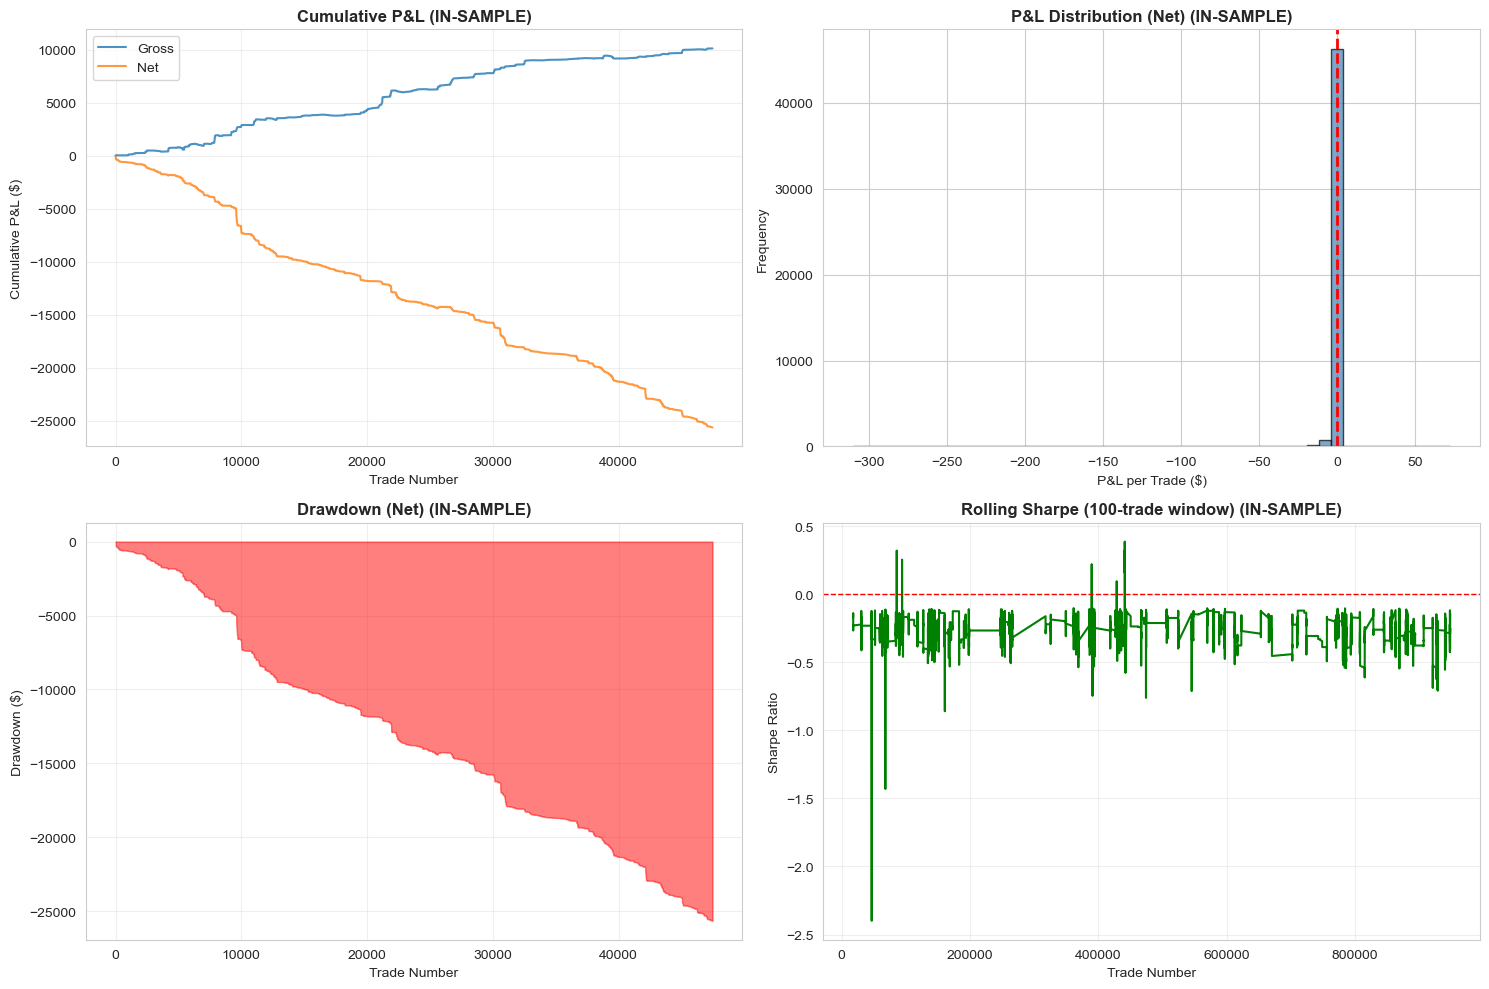

In [15]:
fig = plot_performance(metrics_train_gross, metrics_train_net, trades_train_net, title_suffix=" (IN-SAMPLE)")
plt.show()

## 7. In-Sample: Beta Stability Analysis


=== IN-SAMPLE BETA STABILITY ===


,period,beta,n_obs
0,1,4.975096e-06,"189,939"
1,2,1.849603e-05,"189,939"
2,3,1.029267e-05,"189,939"
3,4,2.364761e-05,"189,939"
4,5,8.827876e-06,"189,939"


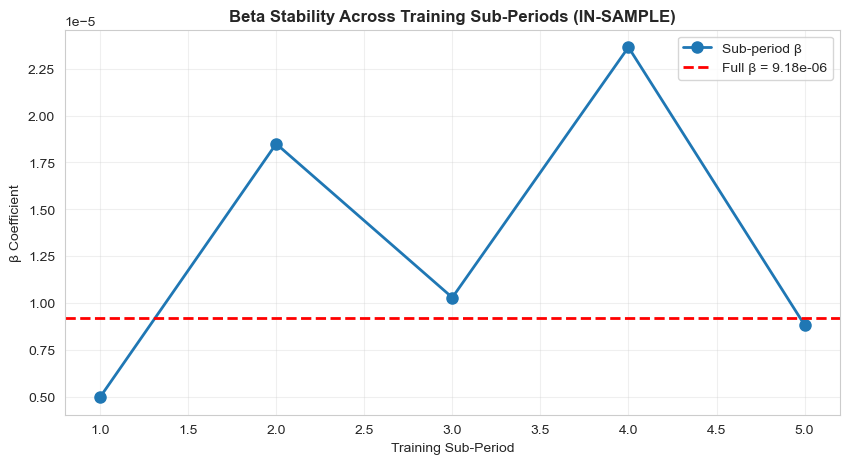

,Statistic,Value
0,Mean β,1.324786e-05
1,Std β,6.817714e-06
2,Coefficient of Variation,51.46%


In [8]:
# Assess beta stability across sub-periods
stability = assess_beta_stability(train_aug, n_splits=5)
stability_display = stability.copy()
stability_display['beta'] = stability_display['beta'].apply(lambda x: f'{x:.6e}')
stability_display['n_obs'] = stability_display['n_obs'].apply(lambda x: f'{x:,}')

print("\n=== IN-SAMPLE BETA STABILITY ===")
display(stability_display)

# Plot stability
betas = stability['beta'].values
plt.figure(figsize=(10, 5))
plt.plot(stability['period'], betas, marker='o', linewidth=2, markersize=8, label='Sub-period β')
plt.axhline(beta, color='red', linestyle='--', linewidth=2, label=f'Full β = {beta:.2e}')
plt.xlabel('Training Sub-Period')
plt.ylabel('β Coefficient')
plt.title('Beta Stability Across Training Sub-Periods (IN-SAMPLE)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Stability statistics
stability_stats = pd.DataFrame([{
    'Statistic': 'Mean β',
    'Value': f'{np.mean(betas):.6e}'
}, {
    'Statistic': 'Std β',
    'Value': f'{np.std(betas):.6e}'
}, {
    'Statistic': 'Coefficient of Variation',
    'Value': f'{np.std(betas)/np.abs(np.mean(betas)):.2%}'
}])
display(stability_stats)

## 8. In-Sample: Volatility Dependence Discovery

**Goal:** Discover if strategy performance depends on market volatility.


=== IN-SAMPLE: P&L BY VOLATILITY DECILE ===
(Discovering volatility-performance relationship)



pl_net                  vol_5min
                mean      std   count     mean
vol_decile                                    
0          -0.162815 1.214391  279508 0.005003
1          -0.068309 0.700312  278523 0.005348
2          -0.202292 1.920321  278898 0.005464
3          -0.657477 4.288585  278943 0.005655
4          -0.248107 1.968046  278937 0.005914
5          -0.733490 4.616971  278941 0.006101
6          -0.667622 4.740744  278971 0.006351
7          -0.261992 2.958593  278935 0.006642
8          -0.234011 2.272228  278962 0.007175
9          -0.513282 3.954327  278933 0.007642

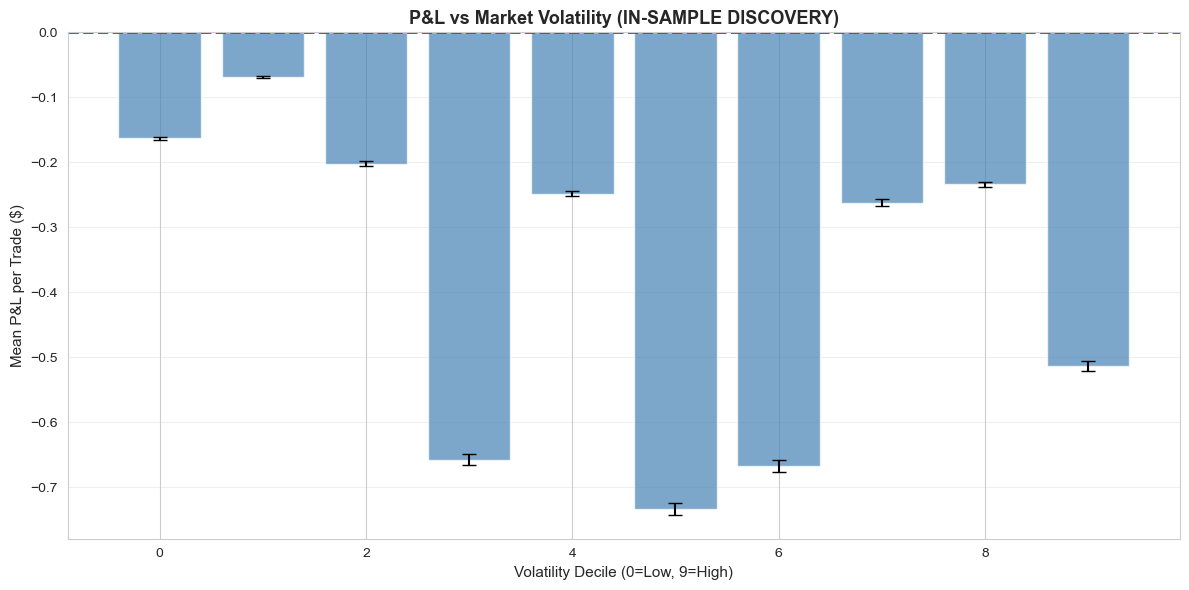


=== DISCOVERIES FROM TRAINING DATA ===


,Finding,Value
0,Best Volatility Deciles,"[1, 0, 2]"
1,Worst Volatility Deciles,"[5, 6, 3]"
2,Best Mean P&L,$-0.0683
3,Worst Mean P&L,$-0.7335


In [9]:
# Add volatility to training data
train_aug_vol = add_volatility(train_aug, window='300s')

# Analyze P&L by volatility regime
vol_analysis_train = analyze_by_volatility(trades_train_net, train_aug_vol)

print("\n=== IN-SAMPLE: P&L BY VOLATILITY DECILE ===")
print("(Discovering volatility-performance relationship)\n")
display(vol_analysis_train)

# Visualize
fig = plot_volatility_analysis(vol_analysis_train, title_suffix=" (IN-SAMPLE DISCOVERY)")
plt.show()

# Identify patterns
mean_pl_by_decile = vol_analysis_train[('pl_net', 'mean')]
best_deciles = mean_pl_by_decile.nlargest(3).index.tolist()
worst_deciles = mean_pl_by_decile.nsmallest(3).index.tolist()

discovery = pd.DataFrame([
    {'Finding': 'Best Volatility Deciles', 'Value': str(best_deciles)},
    {'Finding': 'Worst Volatility Deciles', 'Value': str(worst_deciles)},
    {'Finding': 'Best Mean P&L', 'Value': f"${mean_pl_by_decile[best_deciles[0]]:.4f}"},
    {'Finding': 'Worst Mean P&L', 'Value': f"${mean_pl_by_decile[worst_deciles[0]]:.4f}"}
])

print("\n=== DISCOVERIES FROM TRAINING DATA ===")
display(discovery)

---
# Out of Sample Validation

**Goal:** Validate that patterns discovered in training hold on unseen test data.

**Critical:** We use the same β, threshold j, and apply insights from training.

---

## 9. Out-of-Sample: Apply Model to Test Set

In [10]:
# Compute features on test data
test_aug = compute_flow_and_returns(test, tau_seconds=TAU, T_seconds=T)

# Generate predictions using β from training
test_aug = generate_predictions(test_aug, beta)

# Apply same threshold from training
test_aug['trade_signal'] = test_aug['r_hat'].abs() > j_train

# Strategy summary
strategy_summary_test = pd.DataFrame([{
    'Metric': 'Threshold (j) [from training]',
    'Value': f'{j_train:.6e}'
}, {
    'Metric': 'Participation Rate',
    'Value': f"{test_aug['trade_signal'].mean():.2%}"
}, {
    'Metric': 'Number of Trades',
    'Value': f"{test_aug['trade_signal'].sum():,}"
}])
print("\n=== OUT-OF-SAMPLE (TEST) STRATEGY ===")
display(strategy_summary_test)


=== OUT-OF-SAMPLE (TEST) STRATEGY ===


,Metric,Value
0,Threshold (j) [from training],5.127920e-05
1,Participation Rate,5.91%
2,Number of Trades,"84,148"


## 10. Out-of-Sample: Performance Metrics

In [11]:
# Compute P&L on test data
trades_test_gross = compute_pnl(test_aug, tc_bps=0)
trades_test_net = compute_pnl(test_aug, tc_bps=5)

# Compute metrics
metrics_test_gross = compute_metrics(trades_test_gross['pl_notional'])
metrics_test_net = compute_metrics(trades_test_net['pl_net'])

# Performance table
perf_table_test = pd.DataFrame([
    {'Metric': 'Total P&L', 'Gross': f"${metrics_test_gross['total_pl']:,.2f}", 'Net (5bps TC)': f"${metrics_test_net['total_pl']:,.2f}"},
    {'Metric': 'Mean P&L/Trade', 'Gross': f"${metrics_test_gross['mean_pl']:.4f}", 'Net (5bps TC)': f"${metrics_test_net['mean_pl']:.4f}"},
    {'Metric': 'Sharpe Ratio', 'Gross': f"{metrics_test_gross['sharpe']:.3f}", 'Net (5bps TC)': f"{metrics_test_net['sharpe']:.3f}"},
    {'Metric': 'Max Drawdown', 'Gross': f"${metrics_test_gross['max_dd']:,.2f}", 'Net (5bps TC)': f"${metrics_test_net['max_dd']:,.2f}"},
    {'Metric': 'Win Rate', 'Gross': f"{metrics_test_gross['win_rate']:.2%}", 'Net (5bps TC)': f"{metrics_test_net['win_rate']:.2%}"},
    {'Metric': 'Skewness', 'Gross': f"{metrics_test_gross['skew']:.3f}", 'Net (5bps TC)': f"{metrics_test_net['skew']:.3f}"},
    {'Metric': 'Kurtosis', 'Gross': f"{metrics_test_gross['kurtosis']:.3f}", 'Net (5bps TC)': f"{metrics_test_net['kurtosis']:.3f}"}
])

print("\n=== OUT-OF-SAMPLE PERFORMANCE ===")
display(perf_table_test)

# Tail statistics
tail_table_test = pd.DataFrame([
    {'Percentile': '1%', 'Gross': f"${metrics_test_gross['p01']:.4f}", 'Net': f"${metrics_test_net['p01']:.4f}"},
    {'Percentile': '5%', 'Gross': f"${metrics_test_gross['p05']:.4f}", 'Net': f"${metrics_test_net['p05']:.4f}"},
    {'Percentile': '95%', 'Gross': f"${metrics_test_gross['p95']:.4f}", 'Net': f"${metrics_test_net['p95']:.4f}"},
    {'Percentile': '99%', 'Gross': f"${metrics_test_gross['p99']:.4f}", 'Net': f"${metrics_test_net['p99']:.4f}"}
])

print("\nP&L Tail Statistics:")
display(tail_table_test)


=== OUT-OF-SAMPLE PERFORMANCE ===


,Metric,Gross,Net (5bps TC)
0,Total P&L,"$20,940.68","$-42,723.13"
1,Mean P&L/Trade,$0.2489,$-0.5077
2,Sharpe Ratio,0.050,-0.088
3,Max Drawdown,"$-4,643.34","$-43,554.82"
4,Win Rate,69.91%,9.21%
5,Skewness,19.581,-16.245
6,Kurtosis,974.551,756.190



P&L Tail Statistics:


,Percentile,Gross,Net
0,1%,$-2.5729,$-13.2352
1,5%,$-0.0819,$-1.9835
2,95%,$0.7191,$0.0098
3,99%,$7.3479,$1.7208


## 11. Out-of-Sample: Visualization

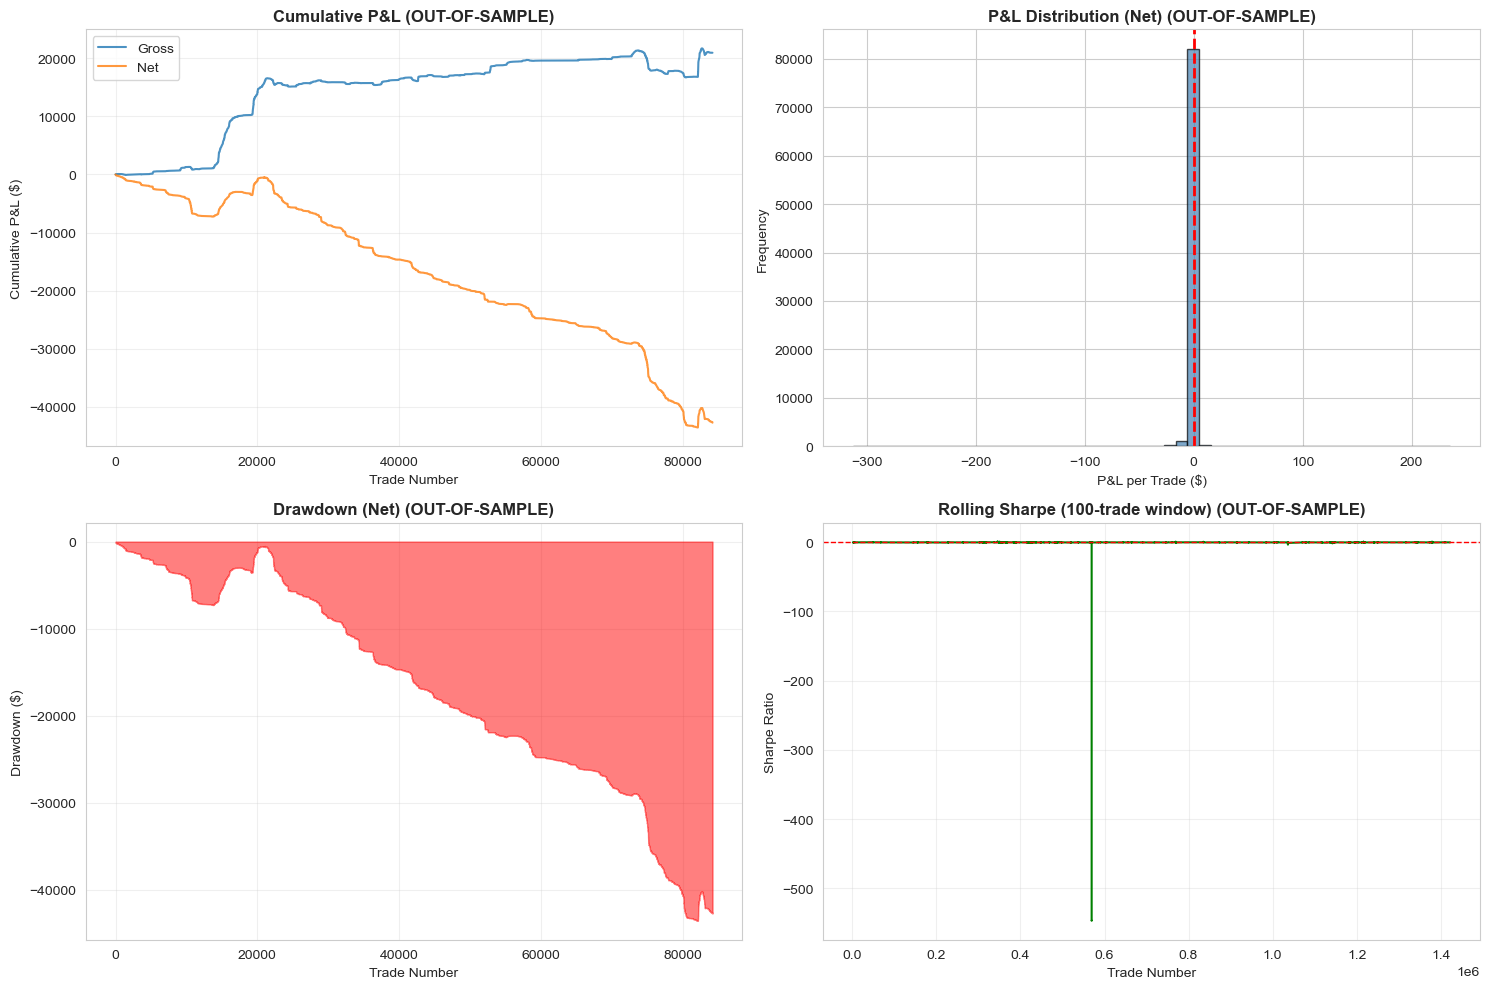

In [12]:
fig = plot_performance(metrics_test_gross, metrics_test_net, trades_test_net, title_suffix=" (OUT-OF-SAMPLE)")
plt.show()

## 12. Out-of-Sample: Volatility Validation


=== OUT-OF-SAMPLE: P&L BY VOLATILITY DECILE ===
(Validating volatility-performance relationship)



pl_net                   vol_5min
                mean       std   count     mean
vol_decile                                     
0           0.543849  5.055188  559340 0.004509
1           0.198051  4.310279  559385 0.004958
2          -0.420277  3.443318  559298 0.005462
3          -1.171393  8.271062  559438 0.005908
4          -0.464479  4.124199  559229 0.006266
5          -0.531188  4.135832  559328 0.006803
6          -0.936905  8.582966  559951 0.007515
7          -2.515880 17.171189  558921 0.008595
8          -0.702483  6.220133  559151 0.010252
9          -0.641003  4.975460  559261 0.011791

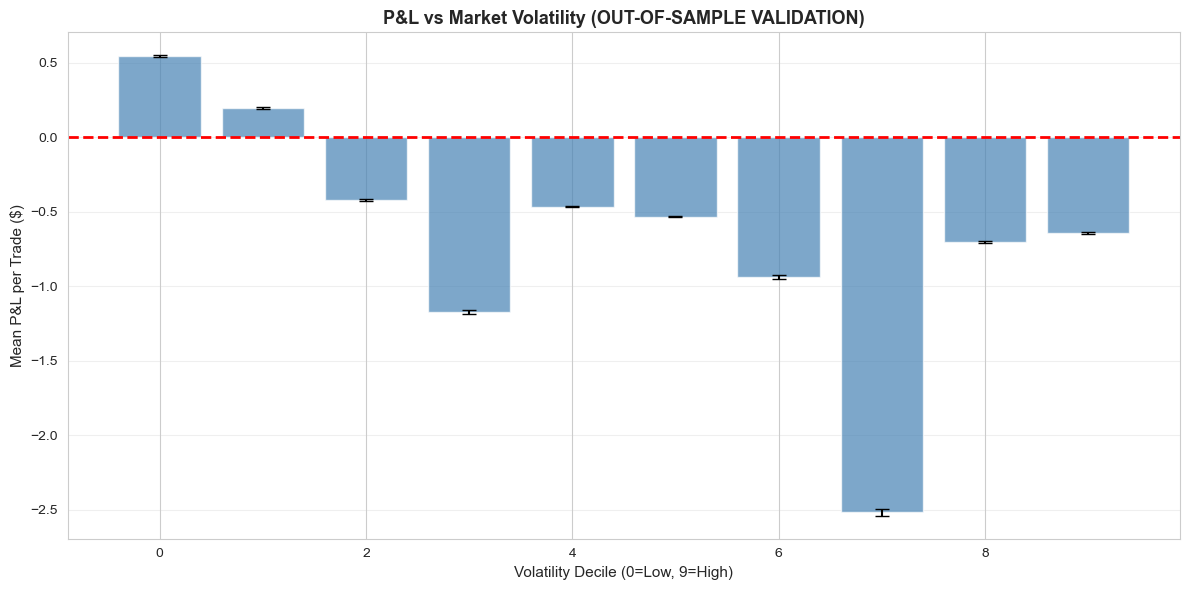

In [13]:
# Add volatility to test data
test_aug_vol = add_volatility(test_aug, window='300s')

# Analyze P&L by volatility regime
vol_analysis_test = analyze_by_volatility(trades_test_net, test_aug_vol)

print("\n=== OUT-OF-SAMPLE: P&L BY VOLATILITY DECILE ===")
print("(Validating volatility-performance relationship)\n")
display(vol_analysis_test)

# Visualize
fig = plot_volatility_analysis(vol_analysis_test, title_suffix=" (OUT-OF-SAMPLE VALIDATION)")
plt.show()

## 13. In-Sample vs Out-of-Sample Comparison


=== IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON ===


,Metric,In-Sample,Out-of-Sample
0,Total P&L (Net),"$-25,646.67","$-42,723.13"
1,Mean P&L/Trade (Net),$-0.5403,$-0.5077
2,Sharpe Ratio (Net),-0.134,-0.088
3,Win Rate (Net),1.86%,9.21%
4,Max Drawdown (Net),"$-25,645.98","$-43,554.82"



=== VOLATILITY ANALYSIS COMPARISON ===


,Decile,In-Sample Mean P&L,Out-of-Sample Mean P&L
0,0,-0.162815,0.543849
1,1,-0.068309,0.198051
2,2,-0.202292,-0.420277
3,3,-0.657477,-1.171393
4,4,-0.248107,-0.464479
5,5,-0.733490,-0.531188
6,6,-0.667622,-0.936905
7,7,-0.261992,-2.515880
8,8,-0.234011,-0.702483
9,9,-0.513282,-0.641003


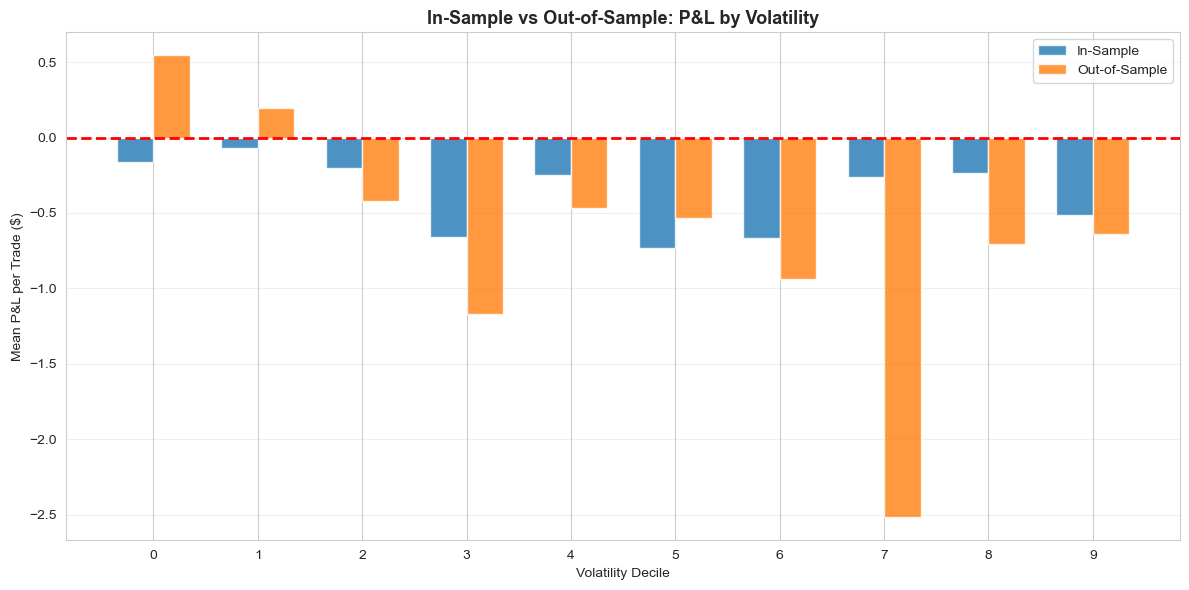

In [14]:
# Performance comparison
comparison = pd.DataFrame([
    {'Metric': 'Total P&L (Net)', 'In-Sample': f"${metrics_train_net['total_pl']:,.2f}", 'Out-of-Sample': f"${metrics_test_net['total_pl']:,.2f}"},
    {'Metric': 'Mean P&L/Trade (Net)', 'In-Sample': f"${metrics_train_net['mean_pl']:.4f}", 'Out-of-Sample': f"${metrics_test_net['mean_pl']:.4f}"},
    {'Metric': 'Sharpe Ratio (Net)', 'In-Sample': f"{metrics_train_net['sharpe']:.3f}", 'Out-of-Sample': f"{metrics_test_net['sharpe']:.3f}"},
    {'Metric': 'Win Rate (Net)', 'In-Sample': f"{metrics_train_net['win_rate']:.2%}", 'Out-of-Sample': f"{metrics_test_net['win_rate']:.2%}"},
    {'Metric': 'Max Drawdown (Net)', 'In-Sample': f"${metrics_train_net['max_dd']:,.2f}", 'Out-of-Sample': f"${metrics_test_net['max_dd']:,.2f}"}
])

print("\n=== IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON ===")
display(comparison)

# Volatility comparison
print("\n=== VOLATILITY ANALYSIS COMPARISON ===")
if len(vol_analysis_train) == len(vol_analysis_test):
    vol_comp = pd.DataFrame({
        'Decile': vol_analysis_train.index,
        'In-Sample Mean P&L': vol_analysis_train[('pl_net', 'mean')].values,
        'Out-of-Sample Mean P&L': vol_analysis_test[('pl_net', 'mean')].values,
    })
    display(vol_comp)
    
    # Visual comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(vol_comp))
    width = 0.35
    ax.bar(x - width/2, vol_comp['In-Sample Mean P&L'], width, label='In-Sample', alpha=0.8)
    ax.bar(x + width/2, vol_comp['Out-of-Sample Mean P&L'], width, label='Out-of-Sample', alpha=0.8)
    ax.axhline(0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Volatility Decile')
    ax.set_ylabel('Mean P&L per Trade ($)')
    ax.set_title('In-Sample vs Out-of-Sample: P&L by Volatility', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(vol_comp['Decile'])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("Cannot compare: different number of volatility deciles")

## 14. Key Findings & Conclusions

### In-Sample Discoveries

- **β Estimate and Stability**:  
  The average in-sample regression coefficient is $\bar{\beta} = 1.32 \times 10^{-5}$, with a standard deviation of $6.82 \times 10^{-6}$, yielding a coefficient of variation of **51.46%**. While the sign of β is consistently positive, its high relative variability indicates that the strength of the trade-flow–return relationship is unstable over time and sensitive to market conditions.

- **Profitability**:  
  Using a threshold of $j = 5.13 \times 10^{-5}$, corresponding to a **5.0% participation rate** (47,469 trades), the strategy generates **\$10,144** in gross in-sample P&L. However, after applying **5 bps transaction costs**, net P&L declines to **–\$25,647**, with the Sharpe ratio falling from **0.077 (gross)** to **–0.134 (net)**. This demonstrates that apparent in-sample profitability is not robust to realistic execution costs.

- **Distributional Characteristics**:  
  In-sample gross P&L exhibits extreme non-normality, with **skewness of 41.9** and **kurtosis exceeding 3,000**, indicating that performance is dominated by rare, large outcomes rather than steady gains. Net P&L tails are strongly negative, consistent with transaction costs overwhelming small predicted returns.

### Out-of-Sample Validation

- **Performance Degradation**:  
  Applying the training-derived threshold $j = 5.13 \times 10^{-5}$ to the test set results in a **5.91% participation rate** (84,148 trades). Gross out-of-sample P&L increases to **\$20,941**, but net P&L deteriorates further to **–\$42,723** after transaction costs. The Sharpe ratio declines from **0.050 (gross)** to **–0.088 (net)**, confirming material degradation relative to in-sample results.

- **Pattern Persistence**:  
  Despite weaker overall performance, the qualitative relationship between volatility and P&L persists out of sample. Low-volatility deciles (0 and 1) achieve positive mean net P&L per trade (**\$0.54** and **\$0.20**, respectively), while higher-volatility deciles consistently exhibit negative average net outcomes, reaching **–\$2.52** per trade in the 8th decile.

- **Statistical Significance**:  
  Although β remains positive on average, its low explanatory power and instability, combined with near-zero Sharpe ratios, suggest that trade flow provides at best weak predictive information that is insufficient for consistent out-of-sample profitability.

### Trading Implications

1. **Transaction Costs**: Transaction costs of **5 bps** are decisive, converting positive gross P&L into large negative net outcomes in both in-sample and out-of-sample tests

2. **Volatility Filtering**: Performance is strongly regime-dependent. Trades executed during the **lowest volatility deciles** dominate relative performance, while high-volatility environments exacerbate losses

3. **Model Stability**: With a β coefficient of variation above **50%**, the relationship between trade flow and returns is not stable enough to justify a fixed-parameter trading strategy

4. **Real-World Viability**: Given sensitivity to costs, heavy-tailed losses, and parameter instability, the strategy is best interpreted as an illustration of microstructure effects rather than a deployable trading system

### Next Steps

1. Extend the analysis to additional exchanges (e.g., OKX) to test cross-market robustness
2. Explore alternative τ and T horizons to identify time scales with stronger signal-to-noise ratios
3. Explicitly restrict trading to favorable volatility regimes identified in the decile analysis
4. Incorporate latency assumptions to better approximate realistic execution constraints
5. Implement rolling or adaptive β estimation to account for time-varying market dynamics